# Prudential life insurance      
데이터셋 - Kaggle      
형태 - 파일데이터(csv)     
생성일자 - 2015년        
다운로드 - https://www.kaggle.com/c/prudential-life-insurance-assessment      

# 1. Introduction

미국 최대의 생명 보험회사 푸르덴셜에서 5년전 제공한 데이터 셋입니다. 이 데이터 세트에는 생명 보험 신청자의 속성을 설명하는 100 개 이상의 변수가 제공됩니다. 테스트 세트의 각 ID에 대한 "Response"변수를 예측하는 것입니다. "Response"은 8 단계의 위험 분류 입니다.

생명보험 청약 프로세스는 평균 30 일 이내에 건강 검진을 포함하여 위험 분류 및 적격성을 식별하기 위해 광범위한 정보를 바탕으로 진행됩니다. 이러한 이유로 미국 가구의 40 %만이 개인 생명 보험을 소유하고 있습니다. 푸르덴셜은 신규 및 기존 고객이 프라이버시 경계를 유지하면서 청약 프로세스를 신속하고 비용 효과적으로 만들고자 합니다. 

향상된 자동화 방식을 사용하여 위험을 정확하게 분류하는 예측 모델을 개발함으로써 업계에 대한 대중의 인식에 큰 영향을 미칠 수 있을 것입니다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['figure.figsize'] = (10, 7)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename = '/content/sample_data/train.csv'
orgin = pd.read_csv(filename)
orgin.shape

(59381, 128)

In [4]:
train = orgin.copy()

In [5]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.08,2,1,1,0.64,0.58,0.15,0.32,0.03,12,1,0.00,3,nan,1,2,6,3,1,2,1,1,1,3,1,0.00,1,1,2,2,nan,0.60,nan,0.53,4.00,112,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.08,2,3,1,0.06,0.60,0.13,0.27,0.00,1,3,0.00,2,0.00,1,2,6,3,1,2,1,2,1,3,1,0.00,1,3,2,2,0.19,nan,0.08,nan,5.00,412,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.08,2,3,1,0.03,0.75,0.29,0.43,0.03,9,1,0.00,2,0.03,1,2,8,3,1,1,1,2,1,1,3,nan,3,2,3,3,0.30,nan,0.23,nan,10.00,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.49,2,3,1,0.16,0.67,0.21,0.35,0.04,9,1,0.00,3,0.20,2,2,8,3,1,2,1,2,1,1,3,nan,3,2,3,3,0.42,nan,0.35,nan,0.00,350,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.23,2,3,1,0.42,0.65,0.23,0.42,0.03,9,1,0.00,2,0.05,1,2,6,3,1,2,1,2,1,1,3,nan,3,2,3,2,0.46,nan,0.41,nan,nan,162,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


#2. Data
 데이터는 Train : Test = 3 : 1 비율로 분리되고 무작위 샘플링으로 이루어진다. Train data는 59,381명, 126개 변수로 구성된 transactional data(low level)이고 , Test data는 19,766명, 126개 변수로 구성된다. Normalized 변수의 범주는 다음과 같다. 
  * **ID** : 청약자의 고유 식별정보 
  * **Product Information** 보험상품 : Info_1 ~ Info_7 
  * **Insurance Age** 보험나이 
  * **Height** 키 
  * **Weight** 몸무게 
  * **BMI** 체질량 지수 
  * **Employment Information** 고용정보 : Info_1 ~ Info_6 
  * **Insured Information** 보험정보 : Info_1 ~ Info_7
  * **Insurance History** 보험내역 : Info_1 ~ Info_9
  * **Family History** 가족력 : Info_1 ~ Info_5
  * **Medical History** 기왕력 : Info_1 ~ Info_41
  * **Medical Keyword** 메디컬 키워드 : Info_1 ~ Info_48 

각 범주에는 class 별 여러 변수가 포함되어 있다. 

* 변수의 유형        
 Continuous, Categorical(명목형 및 순서형) 변수와 Dummy(이진형/지표형) 변수의 유형을 파악한다. 이과정은 모델링 과정에서 변수 선택 및 알고리즘의 선택에 도움이 된다.

 Continous 변수는 요약 통계량, 막대 그래프 및 밀도분포표를 사용하여 분석한다. 범주형 변수는 변수에 따른 결과를 추적하기 위하여 사건 발생률 차트를 사용하여 분석한다.     
  

In [6]:
df = pd.DataFrame(["Product Information",
"Insurance Age",
"Height",
"Weight", 
"BMI",
"Employment Information",
"Insured Information",
"Insurance History",
"Family History",
"Medical History",
"Medical Keyword"], columns = ['Variable_type'])

df['Continous'] = [1,1,1,1,1,3,0,1,4,0,0]
df['Categorical'] = [6,0,0,0,0,3,7,8,1,4,0]
df['Dummy'] = [0,0,0,0,0,0,0,0,0,0,48]
df['Total'] = df.iloc[:, 1:4].sum(axis=1)
df

,Variable_type,Continous,Categorical,Dummy,Total
0,Product Information,1,6,0,7
1,Insurance Age,1,0,0,1
2,Height,1,0,0,1
3,Weight,1,0,0,1
4,BMI,1,0,0,1
5,Employment Information,3,3,0,6
6,Insured Information,0,7,0,7
7,Insurance History,1,8,0,9
8,Family History,4,1,0,5
9,Medical History,0,4,0,4


#3. Missing Value Analysis

* 데이터 처리의 예비 단계로, 결측값 비율이 높은 변수는 제거된다. 제거 임계값은 사용자가 결정하는 것이지만, 이 분석에서의 임계값은 30% 이다.  

In [7]:
train.shape

(59381, 128)

In [8]:
train.isnull().sum().sort_values(ascending=False).head(12)

Medical_History_10     58824
Medical_History_32     58274
Medical_History_24     55580
Medical_History_15     44596
Family_Hist_5          41811
Family_Hist_3          34241
Family_Hist_2          28656
Insurance_History_5    25396
Family_Hist_4          19184
Employment_Info_6      10854
Medical_History_1       8889
Employment_Info_4       6779
dtype: int64

In [9]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in train.columns:
        dtype = str(train[col].dtype)    
        types.append(dtype)
    tt['Types'] = types
    return tt
missing_data(train)['Percent'].sort_values(ascending=False).head(9)

Medical_History_10    99.06
Medical_History_32    98.14
Medical_History_24    93.60
Medical_History_15    75.10
Family_Hist_5         70.41
Family_Hist_3         57.66
Family_Hist_2         48.26
Insurance_History_5   42.77
Family_Hist_4         32.31
Name: Percent, dtype: float64

In [10]:
train=train[train.columns[train.isnull().mean() <= 0.75]]
train.shape

(59381, 124)

* Label encoding

In [12]:
obj_train=list(train.select_dtypes(include=['object']).columns)
obj_train

['Product_Info_2']

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train[obj_train]=le.fit_transform(train[obj_train])

#4. Analysing features

* 요약통계          
기계 학습 알고리즘 변수의 보다 쉬운 통합을 위해 [0, 1] 범위로 정규화한다. 요약 통계량은 기본 데이터 분포를 이해하고, box plot 및 density plot 을 통해 데이터를 시각화하는 데 도움이 된다.

> Box plot 을 사용하면 특히 특이치와 관련하여 데이터 세트를 시각화할 수 있다.         
> Density plot 은 평균, 표준 편차 및 첨도와 같은 통계 지표를 포함하여 분포의 특성을 시각화하는 데 도움이 된다. 또한 반응 변수와 어떤 관계가 있는지 시각적으로 확인할 수 있다. 예를 들면 다음과 같다. 

* Weight

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


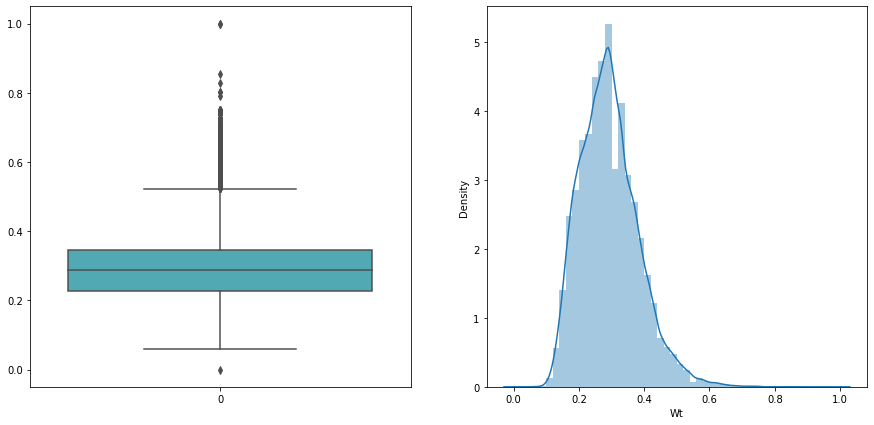

In [14]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Wt'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Wt'], kde=True, ax=axes[1])

* Height

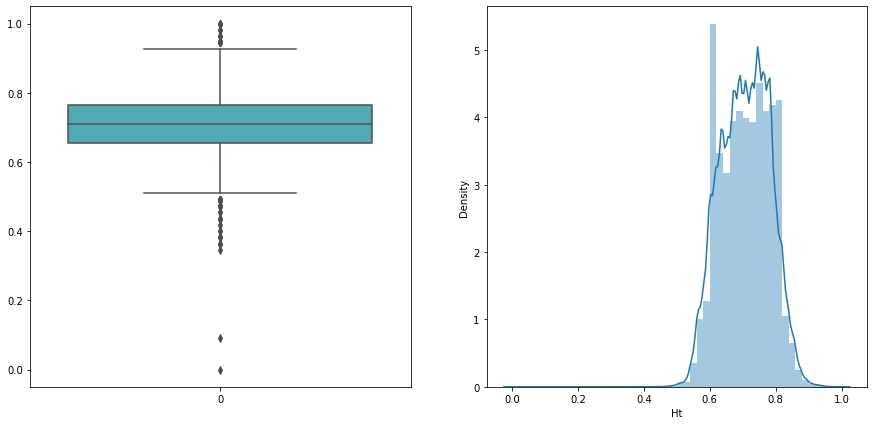

In [15]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Ht'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Ht'], kde=True, ax=axes[1])

* BMI

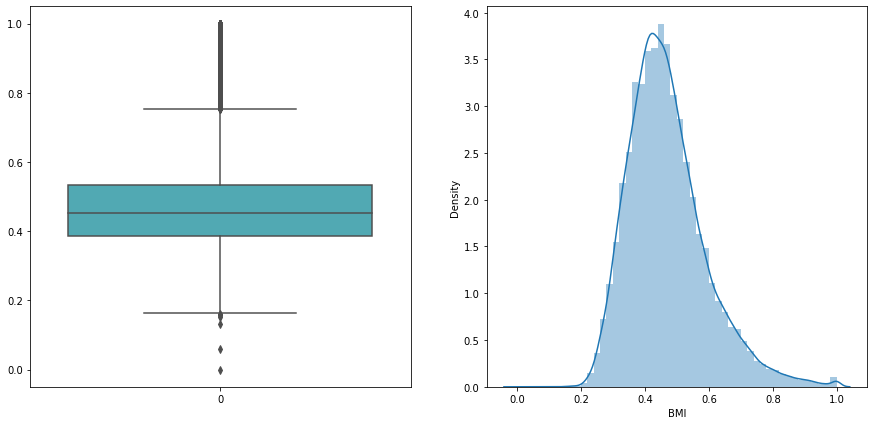

In [16]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['BMI'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['BMI'], kde=True, ax=axes[1])

* Ins_Age

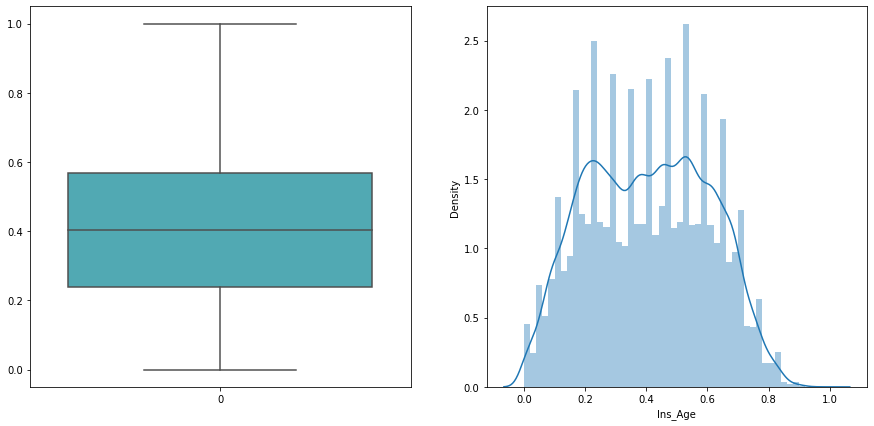

In [17]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Ins_Age'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Ins_Age'], kde=True, ax=axes[1])

* Employment_Info_1

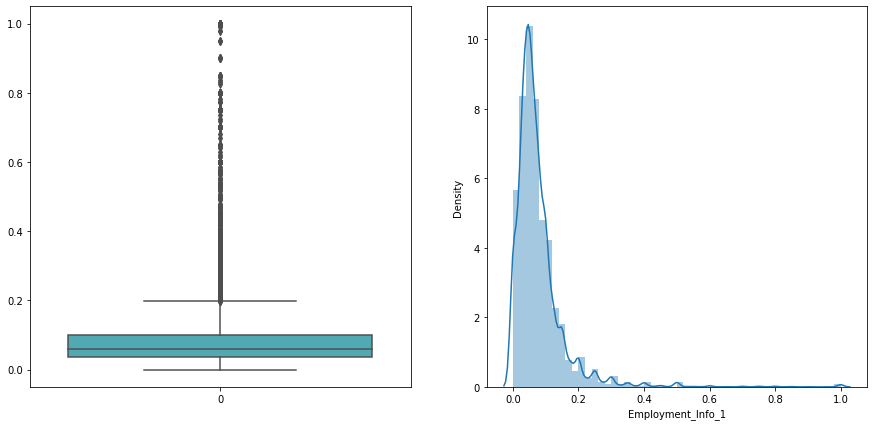

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Employment_Info_1'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Employment_Info_1'], kde=True, ax=axes[1])

* Employment_Info_4

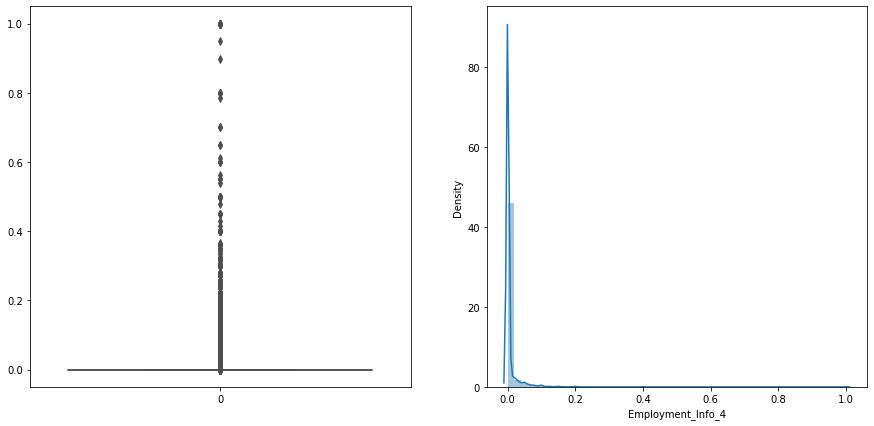

In [20]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Employment_Info_4'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Employment_Info_4'], kde=True, ax=axes[1])

* Employment_Info_6

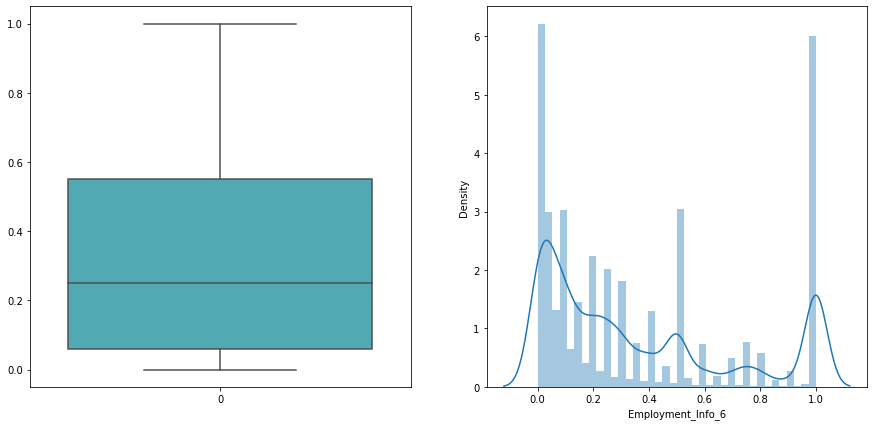

In [22]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Employment_Info_6'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Employment_Info_6'], kde=True, ax=axes[1])

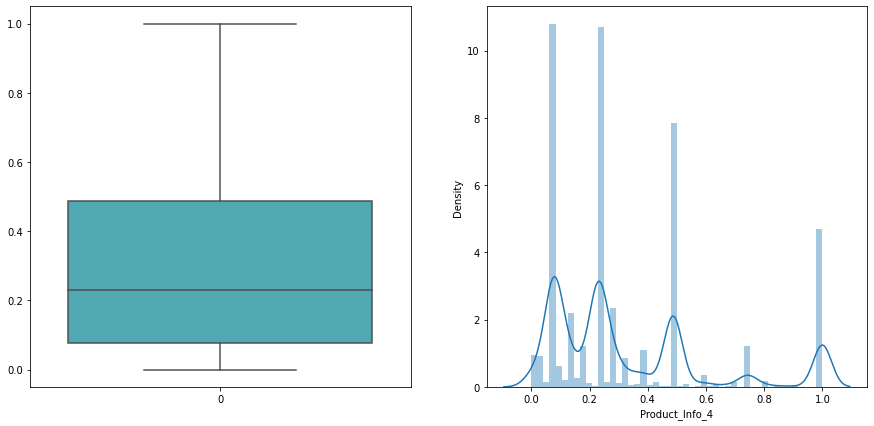

In [23]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data = train['Product_Info_4'], orient = 'v', palette='YlGnBu', ax=axes[0])
sns.distplot(train['Product_Info_4'], kde=True, ax=axes[1])

* 결측값 처리

In [38]:
train.loc[:,['Employment_Info_1','Employment_Info_4','Employment_Info_6']].describe()

,Employment_Info_1,Employment_Info_4,Employment_Info_6
count,59381.00,59381.00,59381.00
mean,0.08,0.01,0.34
std,0.08,0.03,0.32
min,0.00,0.00,0.00
25%,0.04,0.00,0.10
50%,0.06,0.00,0.25
75%,0.10,0.00,0.50
max,1.00,1.00,1.00


In [37]:
list_train = ['Employment_Info_1','Employment_Info_4','Employment_Info_6']
for column in list_train:
    train[column].fillna(train[column].mean(), inplace=True)

* Skewed distribution data analysis

In [53]:
train.groupby('Response')['Employment_Info_4'].count().sort_values(ascending=False)

Response
8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Employment_Info_4, dtype: int64

In [73]:
emp0 = train.loc[train['Employment_Info_4'] < 0.1, ['Employment_Info_4','Response']]
emp0.groupby('Response')['Employment_Info_4'].count().sort_values(ascending=False)

Response
8    19233
6    11091
7     7918
2     6472
1     6102
5     5394
4     1422
3     1005
Name: Employment_Info_4, dtype: int64

In [76]:
age0 = train.loc[train['Employment_Info_4'] < 0.1, ['Employment_Info_4','Ins_Age']]
age0.groupby('Ins_Age')['Employment_Info_4'].count().sort_values(ascending=False)

Ins_Age
0.54    1539
0.52    1531
0.45    1530
0.22    1491
0.19    1473
        ... 
0.90      17
0.91      10
0.93       3
0.97       1
1.00       1
Name: Employment_Info_4, Length: 65, dtype: int64

In [74]:
emp1 = train.loc[train['Employment_Info_4'] > 0.1, ['Employment_Info_4','Response']]
emp1.groupby('Response')['Employment_Info_4'].count().sort_values(ascending=False)

Response
8    190
6    111
7     86
1     75
2     56
5     27
3      6
4      5
Name: Employment_Info_4, dtype: int64

In [77]:
age1 = train.loc[train['Employment_Info_4'] > 0.1, ['Employment_Info_4','Ins_Age']]
age1.groupby('Ins_Age')['Employment_Info_4'].count().sort_values(ascending=False)

Ins_Age
0.69    27
0.70    22
0.57    19
0.61    19
0.58    18
0.66    18
0.49    17
0.67    17
0.52    16
0.64    15
0.45    15
0.63    14
0.51    14
0.48    14
0.28    14
0.75    13
0.37    13
0.60    13
0.73    13
0.54    12
0.55    12
0.43    12
0.22    12
0.46    12
0.81    11
0.36    11
0.33    10
0.78    10
0.76    10
0.30     9
0.72     9
0.27     8
0.31     8
0.24     8
0.25     7
0.40     7
0.39     7
0.18     7
0.19     7
0.79     7
0.21     7
0.16     6
0.82     5
0.42     5
0.34     4
0.84     4
0.15     3
0.85     2
0.03     2
0.10     2
0.13     2
0.06     1
0.09     1
0.91     1
0.12     1
0.90     1
0.87     1
0.00     1
Name: Employment_Info_4, dtype: int64

#4. Target Variable Analysis

* Response

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


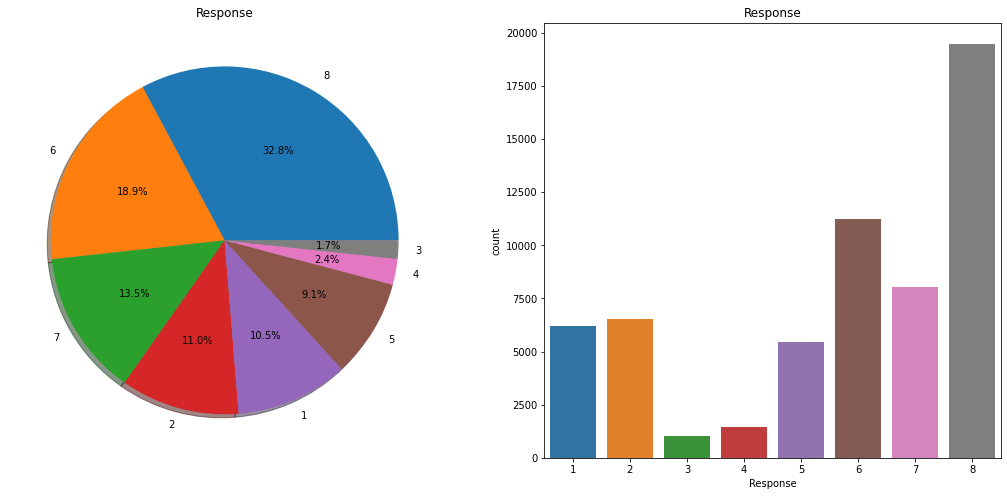

In [24]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Response')
ax[0].set_ylabel('')
sns.countplot('Response',data=train,ax=ax[1])
ax[1].set_title('Response')
plt.show()

* 사고 발생률 차트 
  

* 상관관계표
데이터 분석과 데이터 처리 후, 모델 개발 단계는 변수 감소일 것이다.

#4. 변수 분석      
 

* 주성분 분석


* Boruta Classification Algorithm     
Boruta는 연관성 있는 모든 특징 선택 wrapper algorithmn 이다. 이 방법은 원래 속성의 중요성과 무작위로 시행된 중요도를 비교하여 모든 관련있는 특징에 대하여 top-down 방식으로 수행된다. 관련성이 높은 특징 순서대로 복사본을 만들고, 관련 없는 특징들을 점진적으로 제거한다. 주성분 분석 이후의 모든 속성은 알고리즘에 의해 중요한 것으로 간주된다.

#5. 방법론

* Multinominal Logic Model      
 데이터를 두 부분으로 나누고 한 부분으로 모델을 예측하고 다른 부분은 모델 유효성 검사와 표본예측을 위해 사용한다.        







> Train data 와 Test data 의 반응 분포를 살펴본다.



> Train & Test data의 분포 비교         
분포는 두 부분에 대해 동일하므로 두 부분이 유사한 분포를 따른다고 가정한다.

> Performance Metrics       
Multinominal Logic Model의 Kappa score 는 0.3183794 이다.

* Random Forest        
 데이터를 두 부분으로 나누고 한 부분을 사용하여 모델을 예측하고 다른 부분은 모델 유효성 검사와 표본 예측을 위해 사용한다. 전체 데이터 세트를 예측에 사용할 것이다.        
 

> Train data 와 Test data 의 반응 분포를 살펴본다.



> Train & Test data의 분포 비교         
 분포는 두 부분에 대해 동일하므로 두 부분이 유사한 분포를 따른다고 가정한다.    

> Performance Metrics           
 Random Forest의 Kappa Score는 0.4744071이다.           
Random Forest 예측에 사용되는 Rattel plot(or tree) 은 다음과 같다.

* XGBoost            
XGBoost는 "Extreme Gradient Boosting"의 줄임말로, 여기서 "Gradient Boosting"이라는 용어는 Greedy function approximation 논문에서 제안했다 : Gradient Boosting machine, by Friedman.       
XGBoost는 이 original model 을 기반으로 한다. XGBoost는 학습 문제를 관라하는 데 자주 사용되는데, training data(with multiple features, xi)를 사용하여 target variable(yi)을 예측하는데 사용된다.